# Boltzmann Policy, Random Agent and Rare events, Off-Policy Learning
Grzegorz Malisz
Student Number: 4852370
[GitHub Repository](https://github.com/grzgm/deth)

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

MOVING = True  # extra cleaner plot with moving-average of reward
if MOVING:
    from scipy.signal import savgol_filter

## Code
Provided code was altered to be reused for question. Parameter `is_slippery` has been renamed to `random_termination`. For the ease of testing different parameter values, code was abstracted to the form of function where the most important parameters are provided as arguments.

In [2]:
class Step:
    def __init__(self, state=None, action=None, next_state=None):
        self.state = state
        self.action = action
        self.next_state = next_state


def frozen_lake(frequent_rewards=True, random_termination=True, tau=1):
    # hyper parameters
    learning_rate = 0.1  # impacts how fast we update our estimates
    discount_factor = 0.9  # gamma, impacts the return calculations
    episodes = 4 * 1000  # number of episodes to learn, keep this a multiple of four for nice plotting
    t = 100  # Maximum steps in an episode
    cost_of_living = - 0.01  # used when frequent_rewards = True, incentive the agent for efficiency by incurring a cost to each move

    # Choose environment
    env = gym.make("FrozenLake8x8-v1", is_slippery=random_termination)

    Q = np.zeros([env.observation_space.n, env.action_space.n])
    rewards_per_episode = []
    q_values_at_intervals = []  # Store Q-values at intervals

    # Task 2
    episode_sequences = np.empty([episodes, t], dtype=object)
    hit_goal_first_time = (False, -1)

    for episode in range(episodes):
        state, prob = env.reset()
        total_reward = 0

        for step in range(t):
            # Choose action based on softmax policy
            modified_vector = Q[state, :] / tau
            exp_vector = np.exp(modified_vector - np.max(modified_vector))
            action_probabilities = exp_vector / np.sum(exp_vector)

            action = np.random.choice(env.action_space.n, p=action_probabilities)

            next_state, reward, terminated, truncated, info = env.step(action)

            # Storing episode history
            step_obj = Step(state, action, next_state)
            episode_sequences[episode, step] = step_obj

            # check if hit the goal
            if reward > 0 and not hit_goal_first_time[0]:
                hit_goal_first_time = (True, episode)

            if frequent_rewards:
                if terminated & (reward == 0):
                    reward = reward - 1

                reward = reward + cost_of_living

            # Update Q-value using Q-learning equation
            Q[state, action] += learning_rate * (reward + discount_factor * np.max(Q[next_state, :]) - Q[state, action])
            total_reward += reward
            state = next_state

            if terminated:
                # if reward == 1 + cost_of_living:
                #     print(f"Episode {episode} finished after {step + 1} steps. Success!")
                break

        rewards_per_episode.append(total_reward)

        # Store Q-values at intervals (e.g., every 100 episodes)
        if (episode + 1) % (episodes // 4) == 0:
            q_values_at_intervals.append(np.copy(Q))  # Store a copy of Q-values

    # Plotting rewards per episode
    plt.figure(figsize=(7, 5))
    plt.plot(rewards_per_episode, label='Total Reward')
    plt.title('Rewards per Episode')
    plt.suptitle(f'is_slippery: {random_termination}, frequent_rewards: {frequent_rewards}, tau: {tau}')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    # the plot is too noisy, you can use the scipy package to calculate a moving average
    if MOVING:
        moving_average_window = 20
        moving_averages = savgol_filter(rewards_per_episode, moving_average_window, 3)
        plt.plot(moving_averages, label=f'Moving Average (Window {moving_average_window})', color='orange')

    plt.legend()
    plt.show()

    return (hit_goal_first_time, episode_sequences)

## Boltzmann exploration

### Context

The exploration mechanism is dependent on the Boltzmann exploration, which uses the soft-max function and a temperature ($\tau$) parameter to control the exploration-exploitation trade-off.
Softmax:
* Takes the vector (in our case the array) with possible actions and their expected return.
* Applies the temperature parameter by dividing each element by $\tau$.
* Takes the exponential $e$ of each modified element in the vector.
* Divides each exponentiated value by the sum of all the exponentiated values.

The larger $\tau$ the more equaly probability is distributed between actions no matter their expected return. The smaller $\tau$ the more probable is the action with the highest expected return.
Underneath, there are 4 runs of the code with different temperature $\tau$, showcasing differences in learning. The best configuration is $\tau=0.00005$.

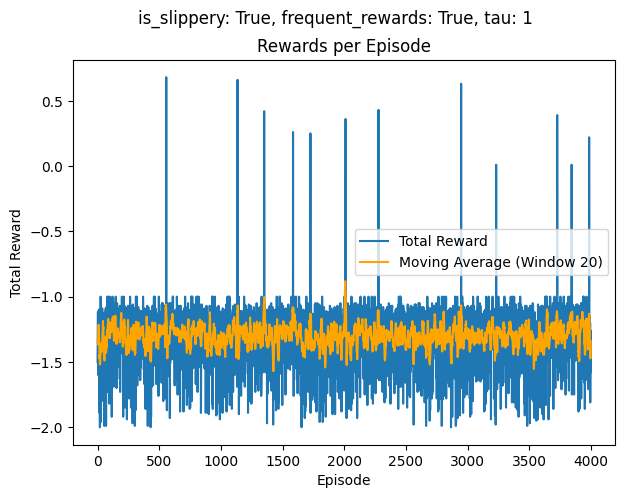

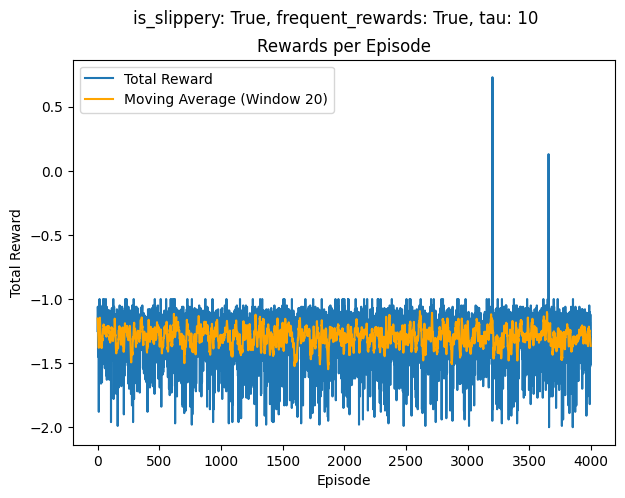

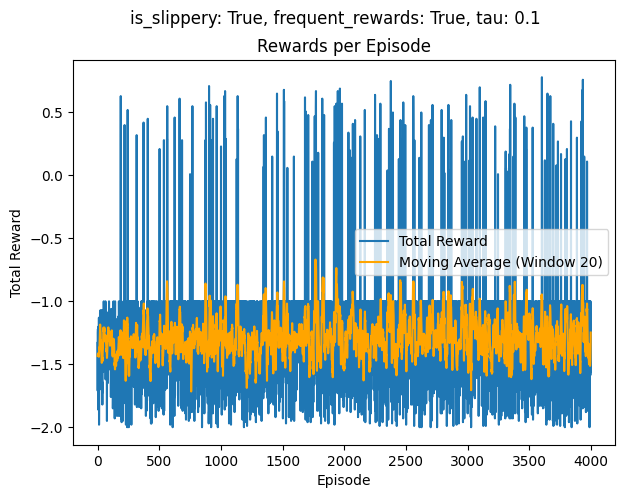

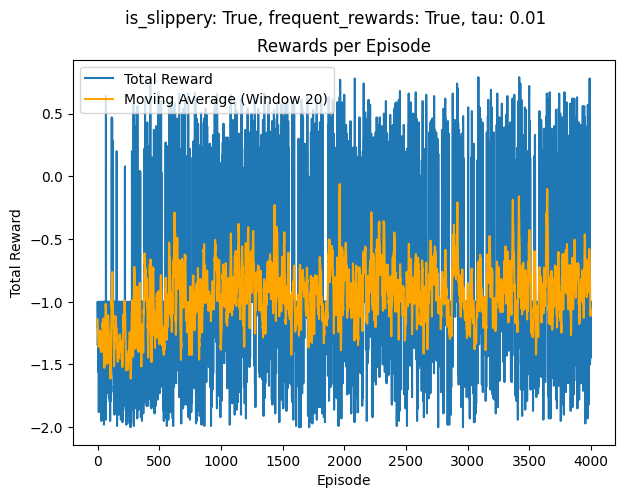

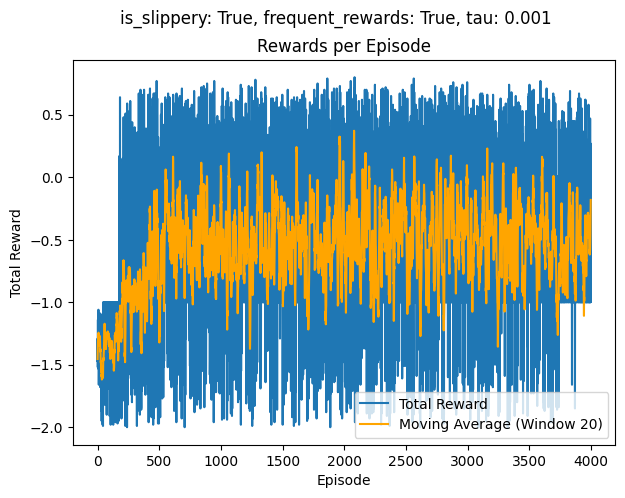

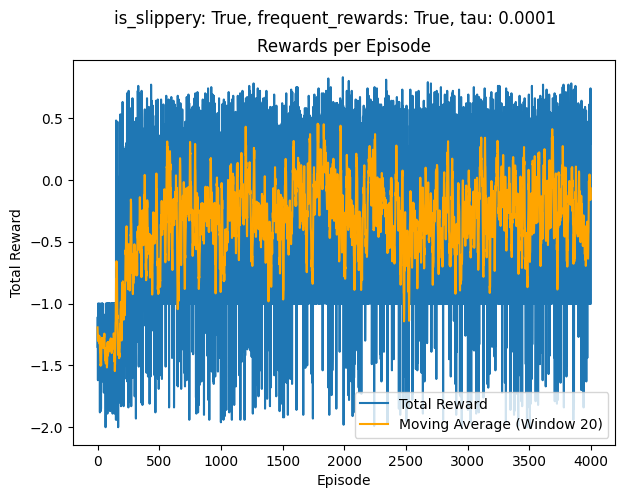

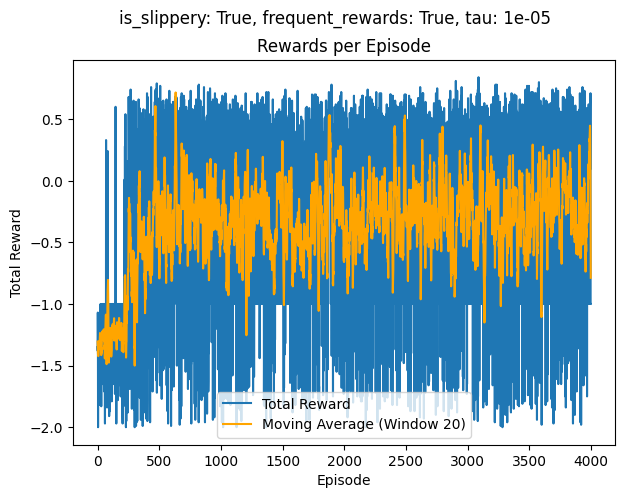

((True, 69),
 array([[<__main__.Step object at 0x000001FCAEB8F450>,
         <__main__.Step object at 0x000001FCAEB8F650>, ..., None, None,
         None],
         <__main__.Step object at 0x000001FCAEB9FDD0>, ..., None, None,
         None],
         <__main__.Step object at 0x000001FCAEB9F390>, ..., None, None,
         None],
        ...,
         <__main__.Step object at 0x000001FCA89A26D0>, ..., None, None,
         None],
         <__main__.Step object at 0x000001FCA89A1F90>, ...,
         <__main__.Step object at 0x000001FCA89A0610>, ...,
         <__main__.Step object at 0x000001FCA88D2DD0>]], dtype=object))

In [3]:
frozen_lake(frequent_rewards=True, random_termination=True, tau=1)
frozen_lake(frequent_rewards=True, random_termination=True, tau=10)
frozen_lake(frequent_rewards=True, random_termination=True, tau=0.1)
frozen_lake(frequent_rewards=True, random_termination=True, tau=0.01)
frozen_lake(frequent_rewards=True, random_termination=True, tau=1e-3)
frozen_lake(frequent_rewards=True, random_termination=True, tau=1e-4)
frozen_lake(frequent_rewards=True, random_termination=True, tau=1e-5)

### Boltzmann vs Epsilon-greedy

Based on the performance of Epsilon-greedy form previous assignment, I don't see much difference between the Boltzmann and Epsilon-greedy. From what I understand and based on the implementations, the Boltzmann requires much lower values then Epsilon-greedy, which might pose implementation problems*, but at the same time Boltzmann prioritises the actions with the higher expected result, where implementation of Epsilon-greedy when wasn't choosing the optimal action, it took uniformly random action from the set of permited.

![title](img/epsilon_greedy.png)

*Similar results for Epsilon-greedy ($\epsilon$) and Boltzmann ($\tau$) required $\epsilon=0.01$ and $\tau=0.00001$

## Random agent and rare events

In this exercise I have created code that runs `frozen_lake(False, False, 1000000)` with required values. The $\tau$ has value of 1000000, to make sure the choices are purly random (the same probability for all possible actions). Next it calculates the mean and $95%$ confidence interval of the number of episodes when the random agent hits the goal for the first time. From my experience the outcomes are really unstable. In addition, it is introducing the class `Step` that is ment to represent step in every episode and is used to store episode history for future use.

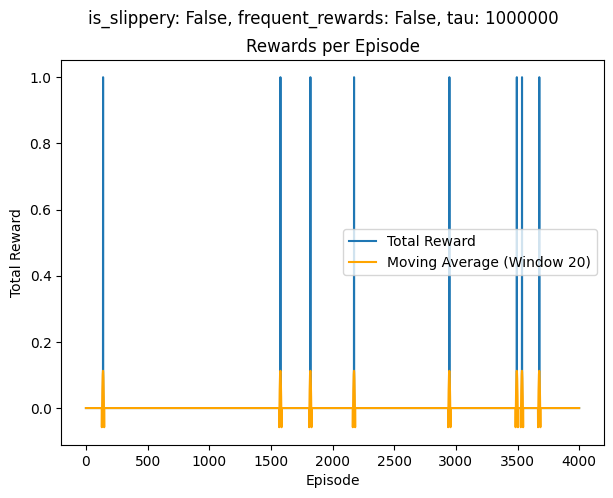

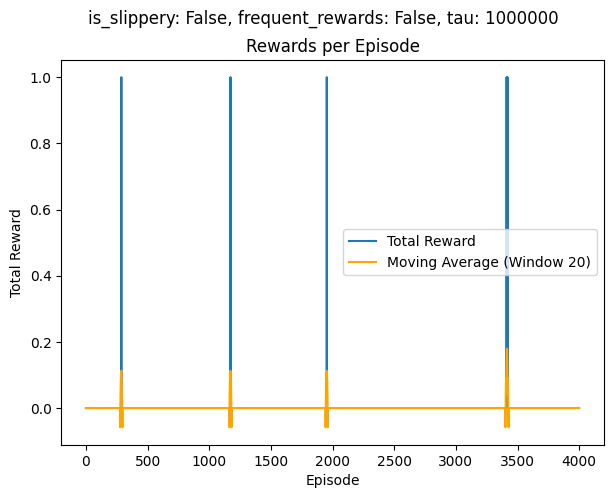

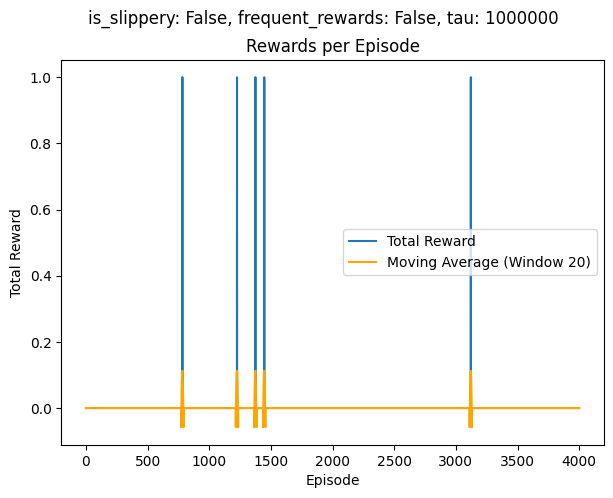

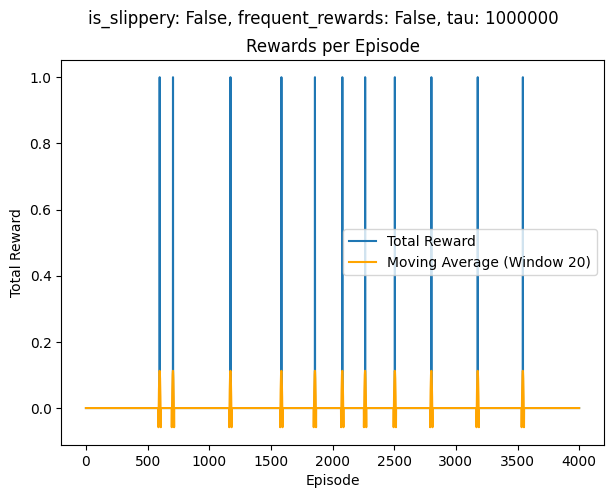

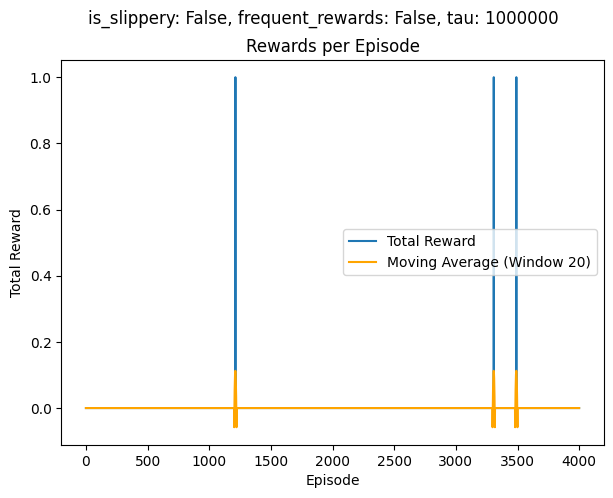

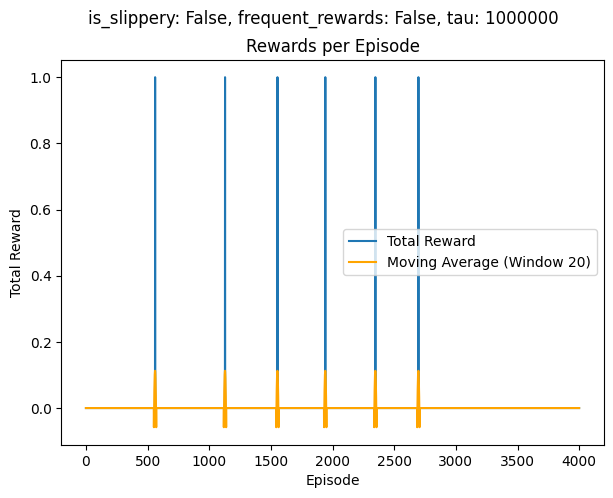

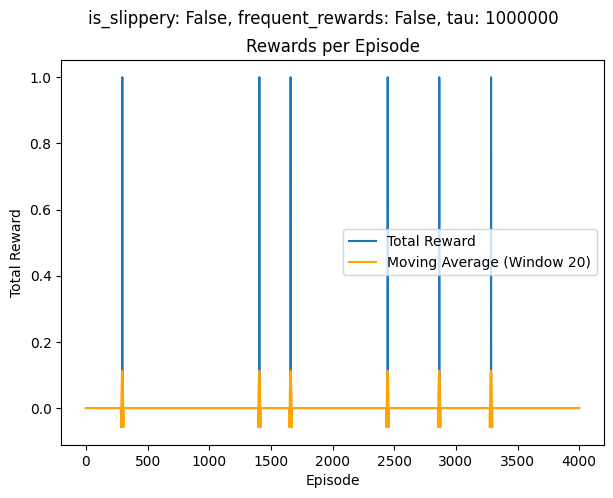

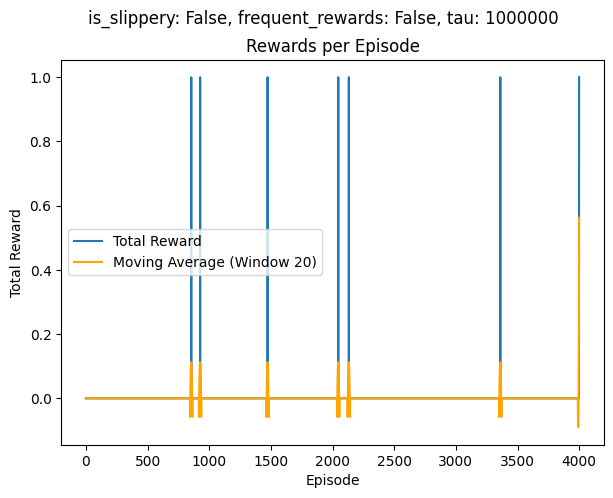

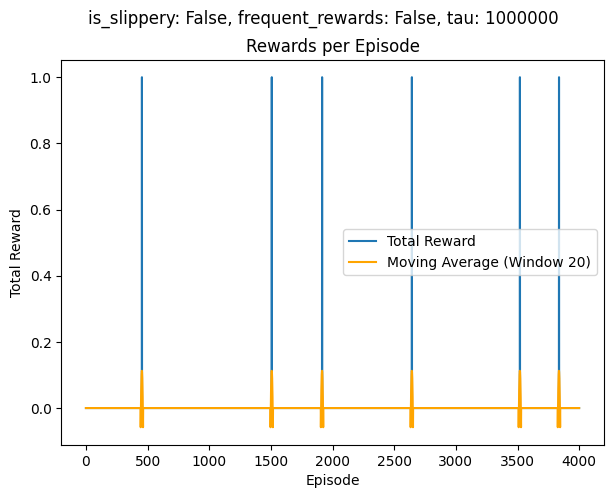

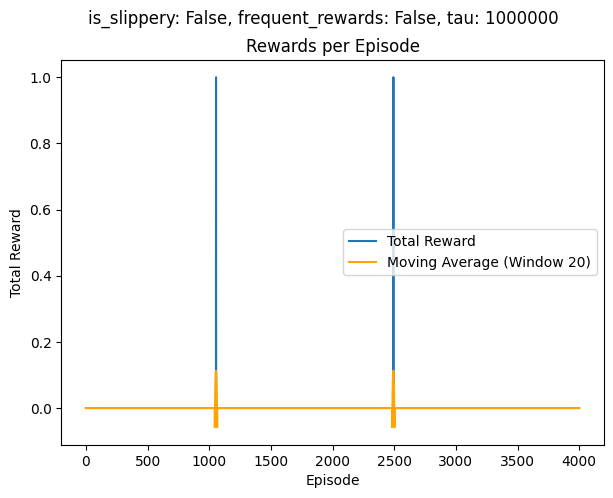

Sample Mean: 623.7
Confidence Interval: (373.6150157533464, 873.7849842466537)


In [4]:
successful_episodes = []

while len(successful_episodes) < 10:
    run = frozen_lake(False, False, 1000000)[0]
    if run[0] == True:
        successful_episodes.append(run[1])

# Calculate sample mean and standard deviation
sample_mean = np.mean(successful_episodes)
sample_std = np.std(successful_episodes, ddof=1)  # Use ddof=1 for sample standard deviation

# Set the desired level of confidence (e.g., 95% confidence interval)
confidence_level = 0.95

# Calculate the critical value from the t-distribution
degrees_of_freedom = len(successful_episodes) - 1
t_critical = stats.t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

# Calculate the margin of error
margin_of_error = t_critical * (sample_std / np.sqrt(len(successful_episodes)))

# Calculate the confidence interval
confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)

print("Sample Mean:", sample_mean)
print("Confidence Interval:", confidence_interval)